<a href="https://colab.research.google.com/github/sachinsharma9780/interactive_tutorials/blob/master/notebooks/Comprehensive_GraphSage_Guide_with_PyTorchGeometric.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Important Note!!
If you are running this notebook on Google Colab, please make sure to enable hardware acceleration using either a GPU or a TPU. If it is run with CPU-only enabled, generating the word embeddings will take an incredibly long time! Hardware acceleration can be enabled by navigating to `Runtime` -> `Change Runtime`. This will present you with a popup, where you can select an appropriate `Hardware Accelerator`.

# A Comprehensive Case-Study of GraphSage Algorithm with Hands-on-Experience using PyTorchGeometric Library and Open-Graph-Benchmark's Amazon Product Recommendation Dataset
This notebook/blogpost provides a comprehensive study on theoretical and practical understanding of [GraphSage](https://arxiv.org/abs/1706.02216) which is an inductive representation learning algorithm. For a practical application we are going to use the popular PyTorch Geometric library and [Open-Graph-Benchmark](https://ogb.stanford.edu/) dataset.

We use [obgn-products](https://ogb.stanford.edu/docs/nodeprop/#ogbn-products) dataset which is an undirected and unweighted graph, representing an <b>Amazon product co-purchasing network to predict shopping preferences</b>. Nodes represent products sold in Amazon, and edges between two products indicate that the products are purchased together. The goal is to predict the category of a product in a multi-class classification setup, where the 47 top-level categories are used for target labels making it a <b>Node Classification Task</b>.

# What is Graph Representation Learning?
Once the graph is created after incorporating meaningful relationships (edges) between all the entities (nodes) of the graph. The next question comes into mind is finding a way to integrate the information about graph structure (for e.g. information about the node's global position in the graph or its local neighbourhood structure) into a machine learning model. One way to extract structural information from the graph is to compute its graph statistics using node degrees, clustering coefficients, kernel functions or hand-engineered features to estimate local neighbourhood structures. However, with these methods we can not perform an end-to-end learning i.e features cannot be learned with the help of loss function during the training process.

To tackle the above problem, representation learning approaches have been adopted to encode the structural information about the graphs into the euclidean space (vector/embedding space). The key idea behind the graph representation learning is to learn a mapping function that embeds nodes, or entire (sub)graphs (from non-euclidean), as points in low-dimensional vector space (to embedding space). The aim is to optimize this mapping so that nodes which are nearby in the original network should also remain close to each other in the embedding space (vector space), while shoving unconnected nodes apart. Therefore by doing this, we can preserve the geometric relationships of the original network inside the embedding space by learning a mapping function. Below diagram (reference: [stanford-cs224w](https://snap-stanford.github.io/cs224w-notes/machine-learning-with-networks/node-representation-learning)) depicts the mapping process, encoder enc maps node <i> u </i> and <i> v </i> to low-dimensional vector <i> z<sub>u </sub> </i> and <i> z<sub>v </sub> </i>:

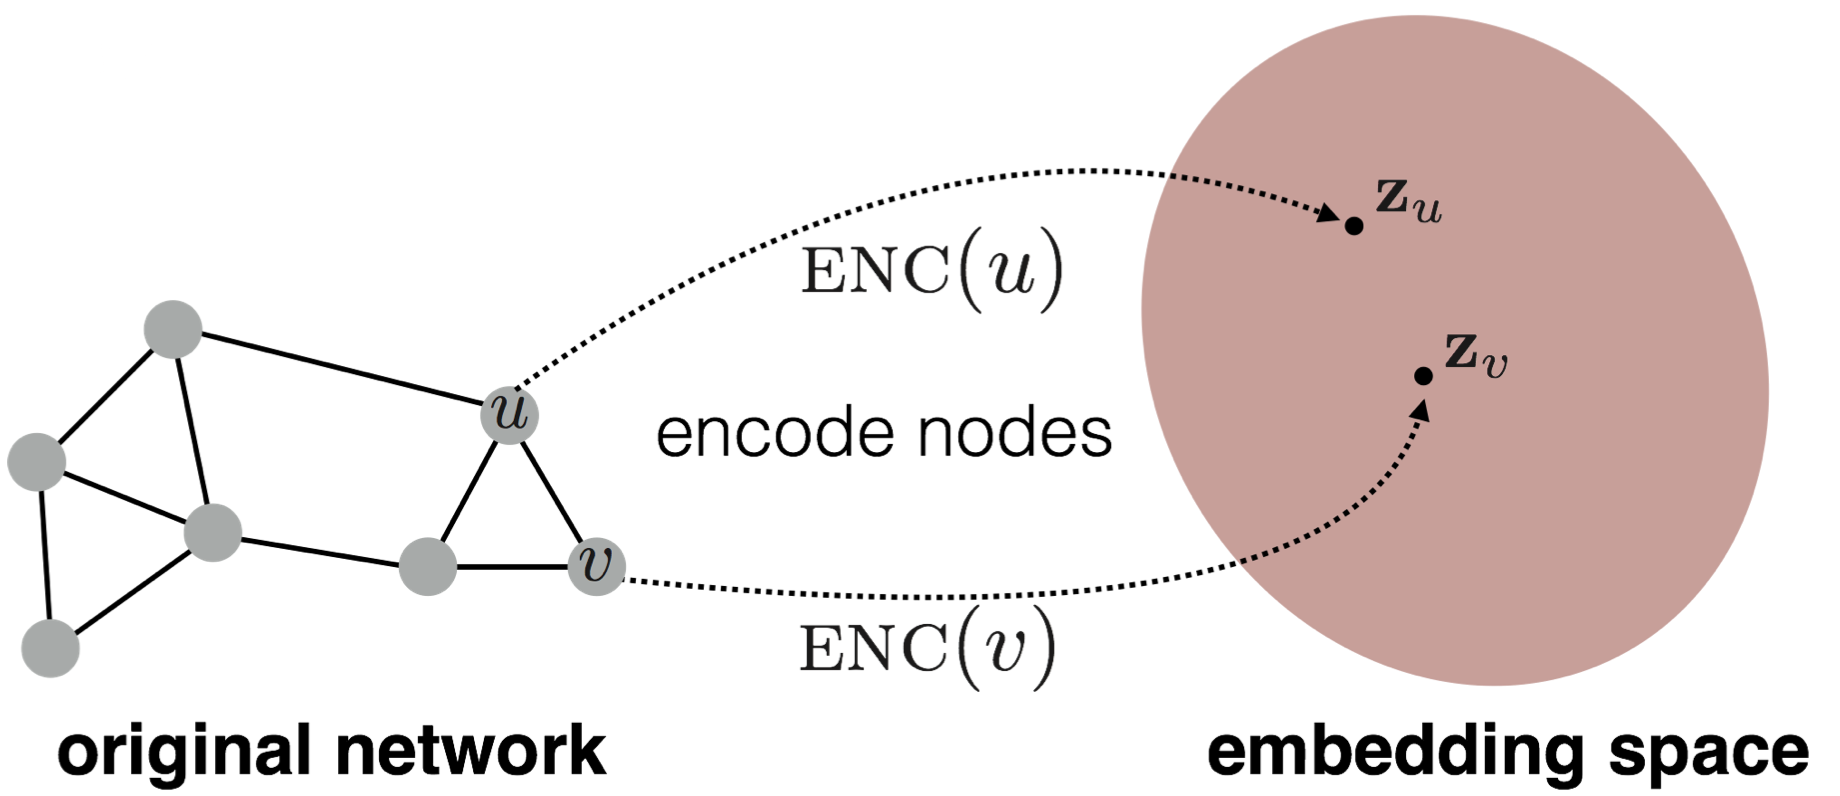





Lets understand this more intutively with an interesting example from the graph structure of the Zachary Karate Club social network. In this graph, the nodes represent the persons and there exists an edge between the two persons if they are friends. The coloring in the graph represents different communities. In the below figure A) represents the Zachary Karate Club social network and B) illustrates the 2D visualization of node embeddings created from the Karate graph using a [DeepWalk](https://arxiv.org/abs/1403.6652) method. If you analyze both the diagrams you will find that the mapping of nodes from a graph structure (non-euclidean or irregular domain) to an embedding space (figure B) is done in such a manner that the distances between nodes in the embedding space mirrors closeness in the original graph (preserving the structure of the node’s neighborhood). For e.g the community of the people marked as violet and green shares close proximity in the karate graph as compared to the communities violet and seagreen which are far away from each other. When the DeepWalk method is applied on the karate graph (in order to learn the node embeddings) we can observe the same proximity behaviour when the learned node embeddings are visualized on 2D space.





## We can use these learned node embeddings for various machine learning downstream tasks: 


1) It can be used as a feature inputs for downstream ML tasks (eg. community detection via node classification or link prediction)

2) We could construct a KNN/Cosine similarity graph from embeddings. The graph could be used to make recommendations (e.g product recommedation)

3) Visual exploration of data by reducing them to 2 or 3 dimensions using U-Map, t-SNE algorithms (eg. performing clustering).

4) Dataset Comparisons

5) Transfer Learning

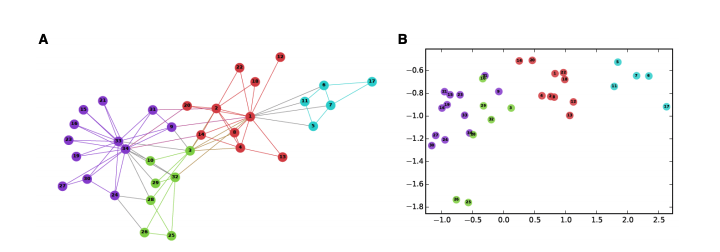

# GraphSage Motivation!!
In this blogpost/notebook, we will cover a [GraphSage](https://arxiv.org/pdf/1706.02216.pdf) (Sample and Aggregate) algorithm which is an <b>inductive</b> (it can generalize to unseen nodes) deep learning method developed by Hamilton, Ying, and Leskovec (2017) for graphs used to generate low-dimensional vector representations for nodes. This is in contrast with the previous graph machine learning methods like [Graph Convolutional Networks](https://arxiv.org/abs/1609.02907) or DeepWalk which are inherently <b>transductive</b> i.e they can only generate embeddings for the nodes present in the fixed graph during the training. 
<br>
This implies that, if in future the graph evolves and new nodes (unseen during the training) make their way into the graph then we need to retrain the whole graph in order to compute the embeddings for the new node. This limitation makes the transductive approaches inefficient to get applied on the ever evolving graphs (like social networks, protein-protein networks, etc) because of their inability to generalize on unseen nodes. The other main limitation of transductive approaches is that they cannot leverage the node features e.g text attributes, node profile information, node degrees, etc.
<br>
On the other hand, the GraphSage algorithm exploits both the rich node features and the topological structure of each node’s neighborhood simultaneously to efficiently generate representations for new nodes without retraining. 

# Working Principles of GraphSage

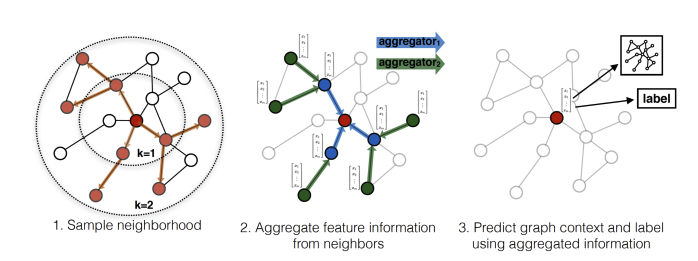

The working process of GraphSage is mainly divided into two steps, first performing <b>neighborhood sampling</b>  of an input graph and the second one is <b>learning aggregation functions</b> at each search depth. We will discuss each of these steps in detail starting with a little motivation of what was the need to perform the sampling of nodes neighborhood. Afterwards, we will discuss the importance of learning aggregator functions which basically had helped GraphSage algorithm to achieve its property of <b>inductiveness</b>. 



## What is the importance of Neighborhood Sampling?

Lets understand this from the perspective of Graph Convolutional Network diagram (GCNs) described below. GCNs is an algorithm which can leverage both the graph topological information (i.e. node's neighborhood) and node features and then distill this  information in order to generate node representations or dense vector embeddings. The below diagram represents the working process of GCNs intuitively. On the left hand side we have a sample input graph where its nodes are represented by their corresponding feature vectors (for e.g. node degree or text embeddings, etc). We start with defining a search depth (K) which informs the algorithm upto what depth it should gather the information from the neighborhood of a target node. Here, K is a hyperparameter and it also depicts the number of layers used in the GCNs. 

At K=0, GCNs initializes all the node embeddings to their original feature vector. Now, let's say we want to compute the embeddings for the target node <i>0</i> at layer K=1, then we <b>aggregate</b> (it is permutation
invariant function to its neighbors) all the feature vectors of nodes (including itself) which are at 1-hop distance from the node <i>0</i> (at this timestep or layer we are aggregating the original feature representations of nodes which are at K=0). For the target node <i>0</i>, GCNs uses a mean aggregator to compute the mean of the neighborhood node features along with its own features (self-loop). After K=1, the target node <i>0</i> now knows about the information about its immediate neighborhood; this process is shown below in the GCNs image (r.h.s). We repeat this process for all the nodes in the graph (i.e. for every node, we aggregate over the 1-hop neighborhood) in order to find the new representations for each node at each layer.

<b>Note:</b> As the search depth increases, the reach of the target node in terms of aggregating features from its local neighborhood also increases. For e.g. at K=1 the target node knows the information about its local neighborhood which are 1-hop distance, at K=2 the target node knows the information about its local neighborhood which are at 1-hop distance and the neighbors of the nodes of 1-hop distance i.e upto 2-hop distance. 

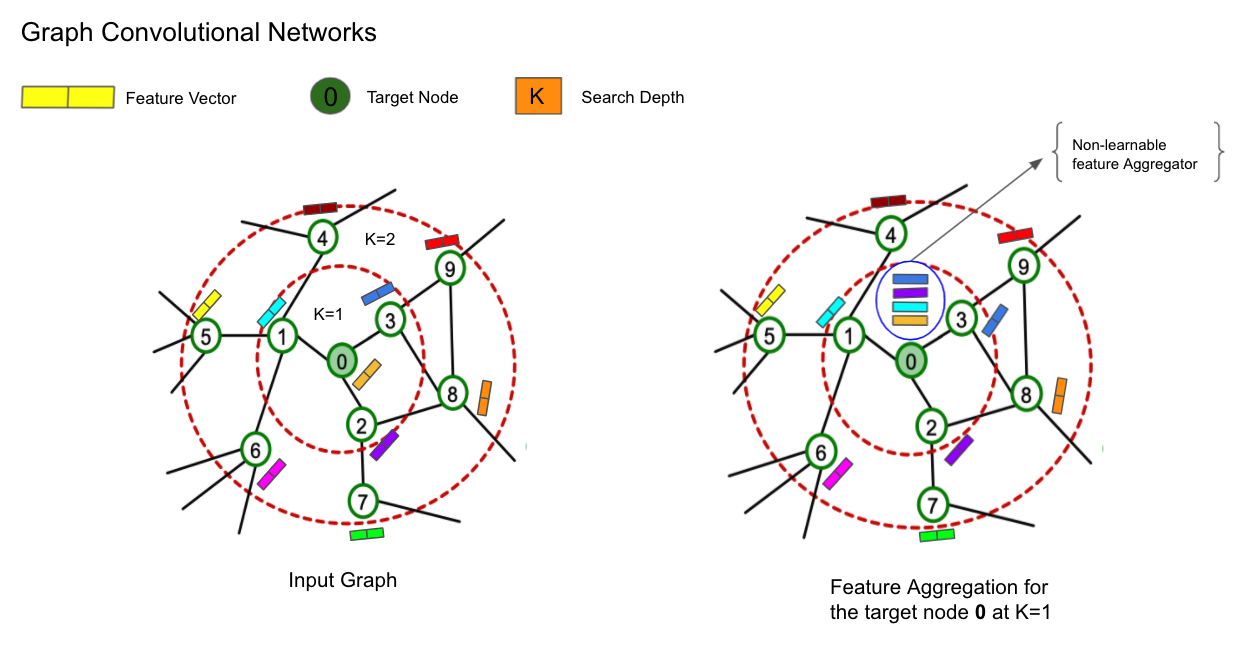

## Issues with GCN approach
As we have discussed above, that GCNs compute node representations using neighborhood aggregation. For the training purposes, we can represent the k-hop neighborhood of a target node as a computational graph and send these computational graphs in a mini-batch fashion in order to learn the weights of the network (i.e. applying stochastic gradient descent). The below diagram illustrates a computational graph for the target node 0 upto 2-hop neighborhood. Now, the problem with this is that:

1) <b>Computationally Expensive</b>: Since for each node, we need to generate the complete K-hop neighborhood computational graph and then need to aggregate plenty of information from its surroundings. As we go deeper into the neighborhood (large K) computation graph becomes exponentially large. This could lead to a problem while fitting these big computational graphs inside GPU memory.

2) <b>The curse of Hub nodes or Celebrity nodes</b>: Hub nodes are those nodes which are very high degree nodes in the graph for eg. a very popular celebrity having millions of connections. If that is the case then we need to aggregate the information from millions of nodes in order to compute the embeddings for the hub node. Therefore, the generated computational graph for the hub node is very huge. This problem is illustrated below diagramatically (r.h.s).


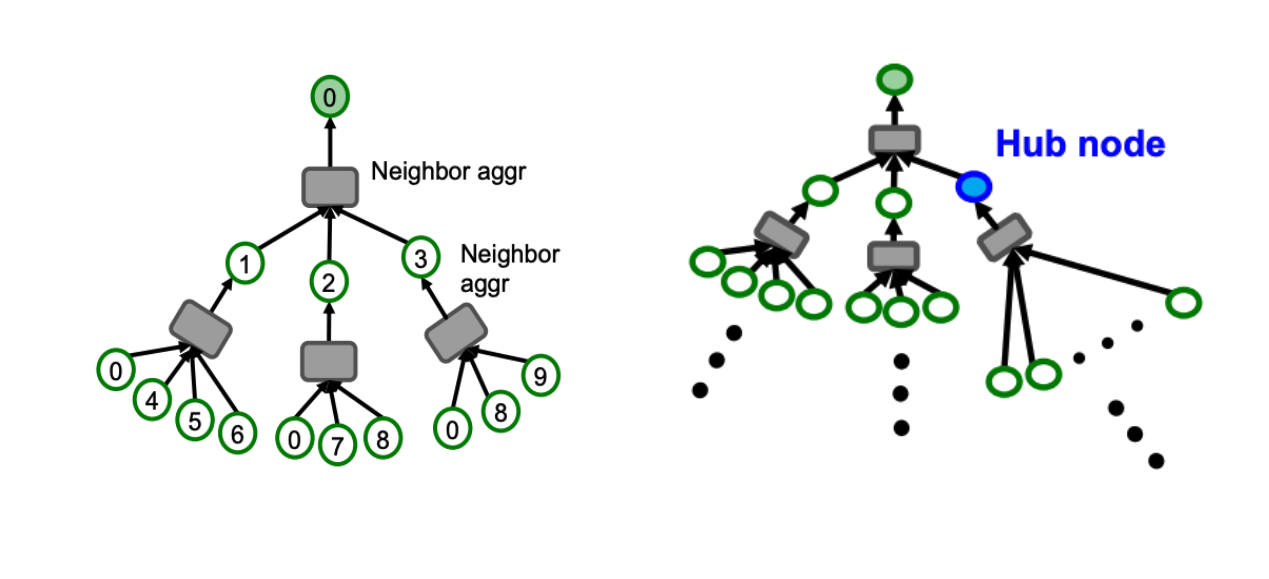

Therefore, the idea is not take the entire K-hop neighborhood of a target node but select few nodes at random from the K-hop neighborhood in order to generate computational graph. This process is known as neighborhood sampling which provides the GraphSage algorithm its unique ability of <b>scaling up to billion of nodes</b> in the graph. Therefore, using this approach if we encounter any hub node then we are not going to take its entire K-hop neighborhood but rather select few nodes at random from each layer or search depth K. Now, the generated computational graph is more efficient to handle by the GPU. Below diagram shows this process by sampling at most 2 neighbors at each hop.

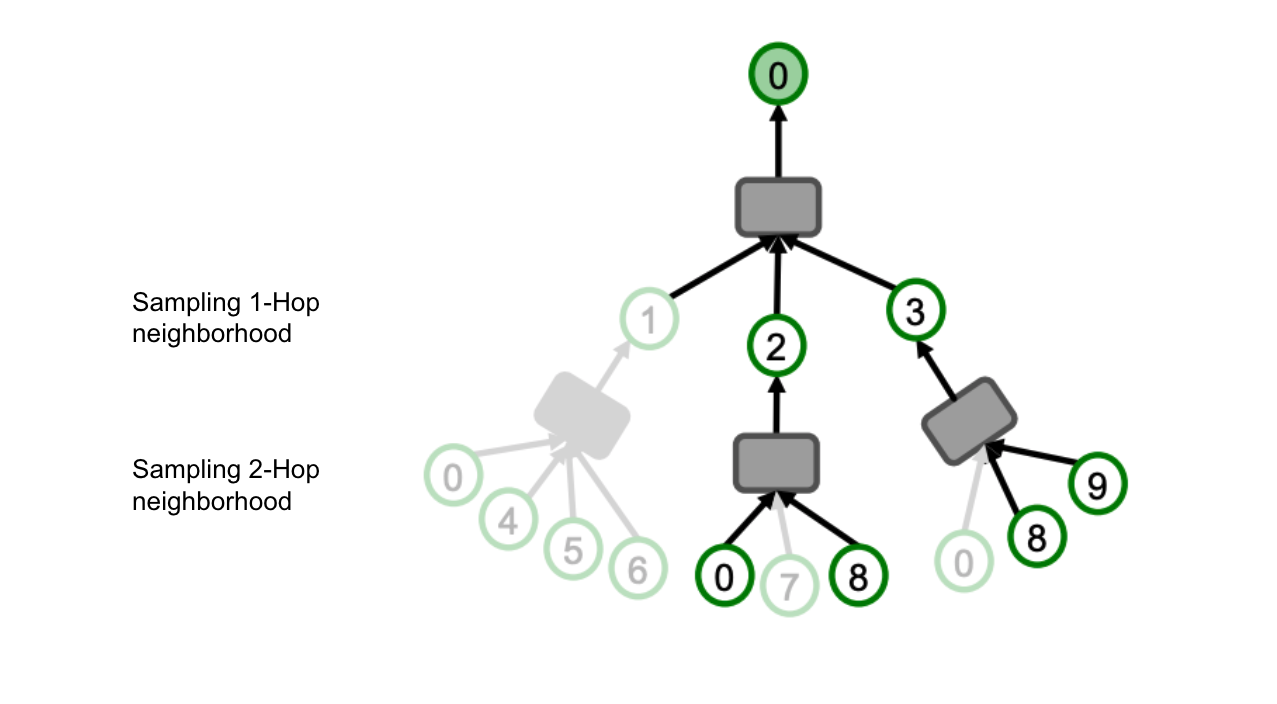

# Why GraphSage is called Inductive Representation Learning algorithm?

GraphSage is an inductive version of GCNs which implies that it does not require the whole graph structure during learning and it can generalize well to the unseen nodes. It is a branch of graph neural networks that learns node representations by sampling and aggregating neighbors from multiple search depths or hops.

Its inductive property is based upon the premises that we don't need to learn the embeddings for each node but rather learn an aggregation function (could be any differentiable function like mean, pooling or lstm) which when given an information (or features) from the local neighborhood of a node then it knows how to aggregate those features (learning takes place via stochastic gradient descent) such that the aggregated feature representation of a node <b>v</b> now includes the information about its local surroundings or neighborhood.

The GraphSage is different from GCNs is two ways: i.e. 1) Instead of taking the entire K-hop neighborhood of a target node, GraphSage first samples or prune the K-hop neighborhood computation graph and then perform the feature aggregation operation on this sampled graph in order to generate the embeddings for a target node.
2) During the learning process, in order to generate the node embeddings; GraphSage learns the aggregator function whereas GCNs make use of the symmetrically normalized graph Laplacian.

The below diagram illustrates how GraphSage node <b>0</b> aggregates information from its sampled local neighbors at search depth K=1. If we observe the r.h.s graph, we will find out that at K=1 the target node <b>0</b> is now having the information about its surroundings upto 1-hop.

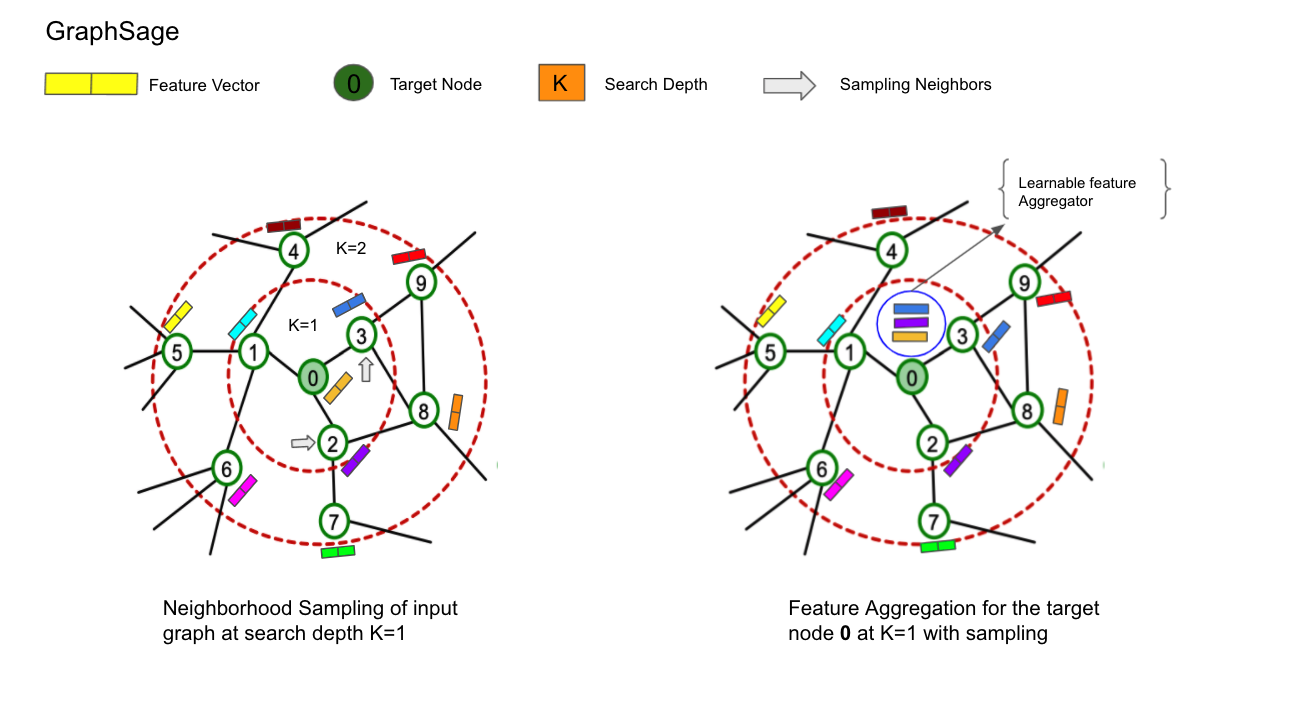

# Formal Explanation of GraphSage

As explained above, the key concept of GraphSage is to learn how to aggregate feature information from a node’s local neighborhood. Now, let's understand more formally how the GraphSage generates node embedding at each layer (K) using forward propagation. We understand this with the help of visuals and then map this understanding to a pseudocode mentioned in the [GraphSage paper](https://arxiv.org/pdf/1706.02216.pdf). But before that, lets define some notations which are used in the paper.

## Defining Notations:

x<sub>v</sub> = Feature vector of a node <b>v</b>

h<sub>v</sub><sup>0</sup> = Initial node embeddings representation for a node <b>v</b> (original feature vectore e.g. text or image embeddings)

h<sub>v</sub><sup>k</sup>  = Node embedding representation for a node <b>v</b> at the K-th layer or search depth

z<sub>v</sub> = Final representation of a node <b>v</b> after K layers

V = Set of nodes in the graph

W<sup>K</sup> = Weight matrix at the K-th layer 

<i>N</i> : v → 2<sup>v</sup> = Neighborhood function



As seen in the above GraphSage diagram that at K=1, the target node <b>0</b> aggregates information (features) from its local neighbors upto 1-hop. Similarly at k=2, the target node <b>0</b> aggregates information from its local neighbors upto 2-hops i.e now it knows what lies in its neighborhood upto 2-hops. Therefore, we can iterate this process where target node <b>0</b> incrementally obtain more and more
information from further reaches of the graph. We do this process of information gathering for each of the nodes in the original graph (∀v ∈ V). 
Lets add some visuals to understand this iterative process much more intuitively:

The following image depicts the computation graph of target node <b>0</b> at layer K=0, at this point of time all the nodes in the graph are initialized to their original feature vectors. Our aim is to find the final representation of node <b>0</b> (i.e z<sub>0</sub>) at layer K=2 through an iterative local neighborhood information gathering process. This iterative process is also sometime known as <b>message passing approach </b>.

Therefore, we can represent this step formally as :

# <b>h<sub>v</sub><sup>0</sup> ← x<sub>v</sub>, ∀v ∈ V </b>

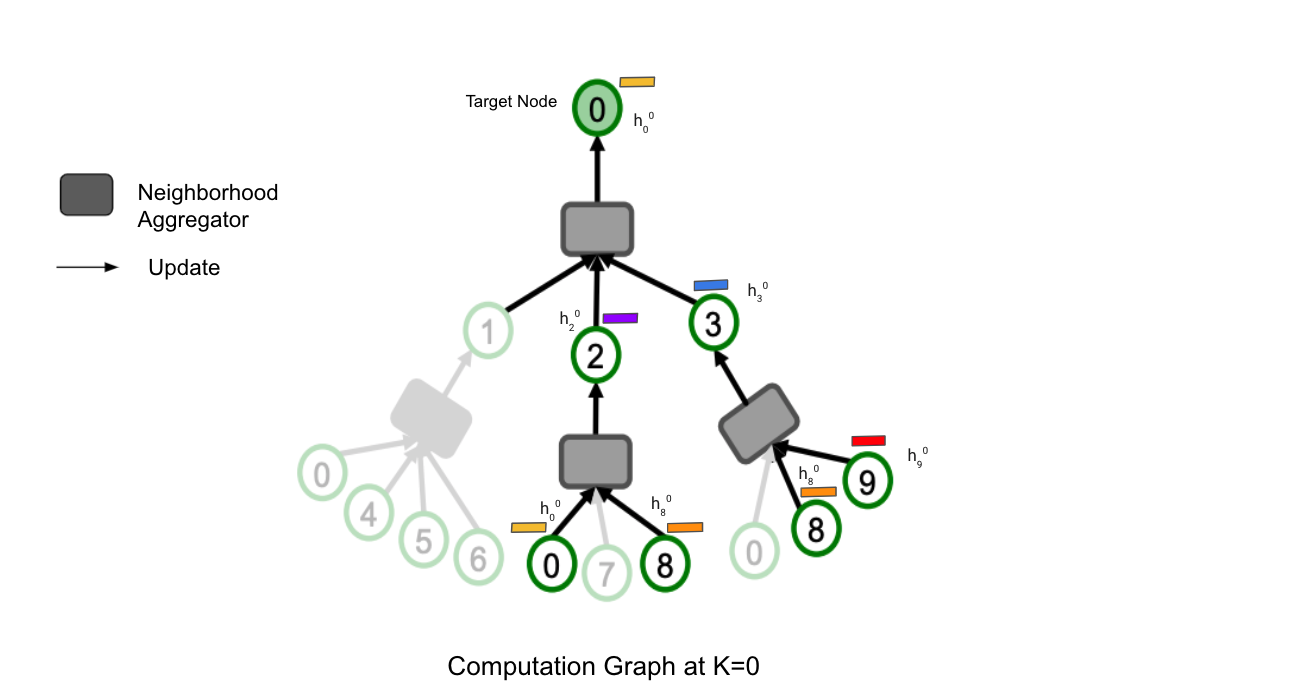

## Neighborhood Aggregation (At K=1)

Since nodes gather the information incrementally from the deeper depths of the graph, we start our iteration process from search depth 1....K. At K=1, we aggregate neighbouring node representations for our target node <b>0</b> (h<sub>0</sub><sup>1</sup>), i.e node 2 and 3 representations which were at previous layer (h<sub>2</sub><sup>K-1</sup> and h<sub>3</sub><sup>K-1</sup>) into a single vector. Here h<sub>0</sub><sup>1</sup> is an aggregated representation. At the same time step, nodes 2, 3, and 9 will also aggregate the feature vectors from their respective local neighborhoods upto distance of 1-hop. Now at this point of time, each of the nodes in a computation graph knows what kind of information lies in their immediate surroundings. 

Therefore, we can represent this step formally as :


Screenshot 2021-08-06 at 11.37.47.png

## Updation

Once we achieve the aggregated representation i.e h<sub>0</sub><sup>1</sup>, the next step would be to concatenate or combine this aggregated representation with its previous layer representation (h<sub>0</sub><sup>0</sup>). Then transformation is applied on this concatenated output by multiplying it with a weight matrix <b>W<sub>K</sub></b>, you can think of this process similar to applying convolutional kernels (learnable weight matrices) on images in order to extract features from it. At the end, we apply a non-linear activation function on this transformed output making it capable to learn and perform more complex tasks.

<b>Important Note</b>: The GraphSage algorithm learns the weight matrix individually at each search depth K or you can also say that it learns how to aggregate information from a node's neighborhood at each search depth. 

Hence, we can represent this step formally as :

Screenshot 2021-08-06 at 12.37.08.png

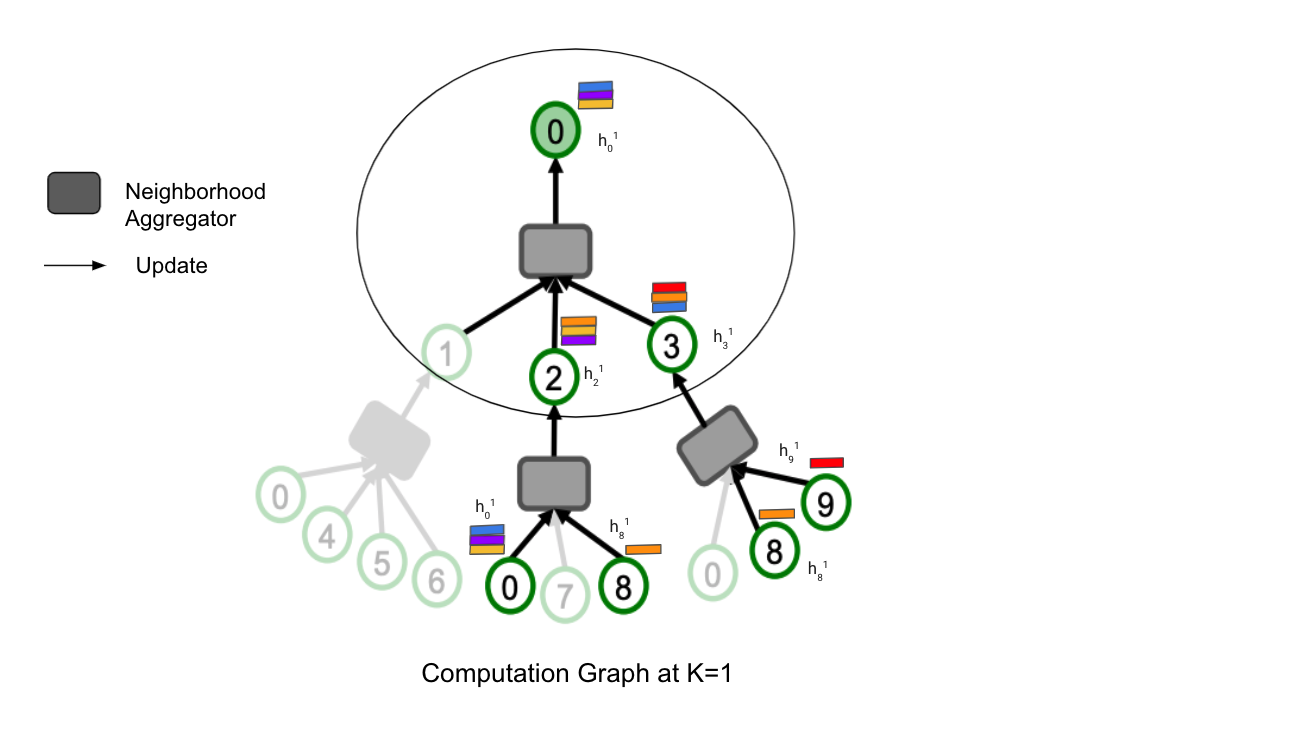

## Normalizing Node Embeddings
Subsequently, normalization is applied on node representation h<sub>v</sub><sup>k</sup> (or at this time step h<sub>0</sub><sup>1</sup>) which helps the algorithm to maintain the general distribution of node embeddings. This step is computed as :


Screenshot 2021-08-06 at 12.48.01.png

## Node Embeddings at K=2
The information gathering from node's local neighborhood at K=1 is completed. At K=2, nodes explore the further reaches of the graph i.e going beyond their immediate neighborhoods and looking into a hop distance of 2. Again we perform the node's local neighborhood aggregation, but this time the target node <b>0</b> will now have the information of its neighbors which are at 1-hop and 2-hop distances.
Then again we repeat the process of updation and normalization for the search depth K=2. Since we have set the value of K=2 for understanding the flow of the GraphSage algorithm therefore,we will stop here. After K=2, each node in the computation graph is represented by their respective final node embeddings i.e. <b>z<sub>v</sub></b>.

This workflow is shown below in the image:

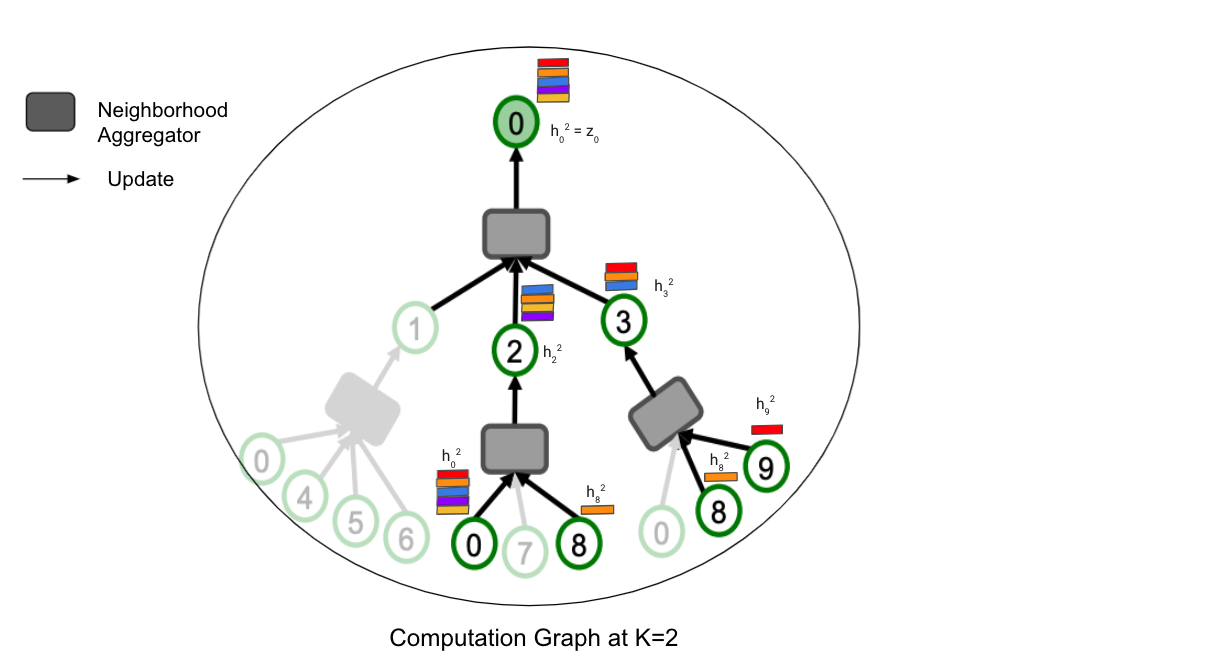

## Now, we can easily map our understanding to the following GraphSage algorithm from the paper:

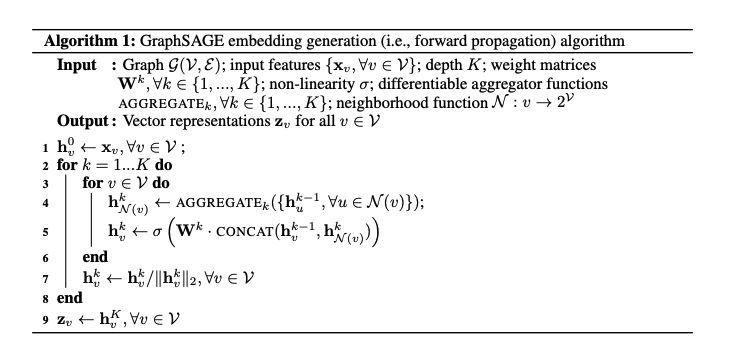

# Loss Function: Learning the parameters

Authors have recorded the results in the paper by using two different types of loss functions which are as following:

<b>Unsupervised Case</b>: As described in the graph representation learning section, the aim is to optimize the mapping so that nodes which are nearby in the original network should also remain close to each other in the embedding space (vector space), while shoving unconnected nodes apart. 

<b>Supervised Case</b>: Authors use regular cross-entropy loss for performing the task of node classification.

Below is the unsupervised loss function used in the paper:

Screenshot 2021-08-06 at 13.51.26.png

# Hands-On-Experience on GraphSage with PyTorch Geometric Library and OGB Benchmark Dataset!

We will understand the working process of GraphSage in more detail with the help of a real world dataset from the [Open Graph Benchmark](https://ogb.stanford.edu/) (OGB) datasets. The OGB is a collection of realistic, large-scale, and diverse benchmark datasets for machine learning on graphs developed by Stanford university. <br>



## Dataset
<b>Dataset</b>: We use [obgn-products](https://ogb.stanford.edu/docs/nodeprop/#ogbn-products) dataset which is an undirected and unweighted graph, representing an Amazon product co-purchasing network. Nodes represent products sold in Amazon, and edges between two products indicate that the products are purchased together. Node features represent bag-of-words features taken from the product descriptions. The goal is to predict the category of a product in a multi-class classification setup, where the 47 top-level categories are used for target labels making it a <b>Node Classification Task</b>. 

 ## Lets start with downloading necessary libraries

In [ ]:
# Installing Pytorch Geometric 
%%capture
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
!pip install -q torch-cluster -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
!pip install -q torch-geometric
!pip install ogb
!pip install umap-learn

In [ ]:

import torch
import torch.nn.functional as F
from tqdm import tqdm
from torch_geometric.data import NeighborSampler
from torch_geometric.nn import SAGEConv
import os.path as osp
import pandas as pd
import numpy as np
import collections
from pandas.core.common import flatten
# importing obg datatset
from ogb.nodeproppred import PygNodePropPredDataset, Evaluator
from pandas.core.common import flatten
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(16.7,8.27)})
sns.set_theme(style="ticks")
import collections
from scipy.special import softmax
import umap

In [ ]:
# download and loading the obg dataset
root = osp.join(osp.dirname(osp.realpath('./')), 'data', 'products')
dataset = PygNodePropPredDataset('ogbn-products', root)

In [ ]:
# split_idx contains a dictionary of train, validation and test node indices
split_idx = dataset.get_idx_split()
# predefined ogb evaluator method used for validation of predictions
evaluator = Evaluator(name='ogbn-products')

Lets check the training, validation and test node split.

In [ ]:
# lets check the node ids distribution of train, test and val
print('Number of training nodes:', split_idx['train'].size(0))
print('Number of validation nodes:', split_idx['valid'].size(0))
print('Number of test nodes:', split_idx['test'].size(0))

In [ ]:
# loading the dataset
data = dataset[0]

Graph Statistics of the dataset

In [ ]:
# lets check some graph statistics of ogb-product graph
print("Number of nodes in the graph:", data.num_nodes)
print("Number of edges in the graph:", data.num_edges)
print("Node feature matrix with shape:", data.x.shape) # [num_nodes, num_node_features]
print("Graph connectivity in COO format with shape:", data.edge_index.shape) # [2, num_edges]
print("Target to train against :", data.y.shape) 
print("Node feature length", dataset.num_features)

In [ ]:
# checking the number of unique labels
# there are 47 unique categories of product
data.y.unique()

In [ ]:
# load integer to real product category from label mapping provided inside the dataset
df = pd.read_csv('/data/products/ogbn_products/mapping/labelidx2productcategory.csv.gz')

In [ ]:
# lets see some of the product categories
df[:10]

In [ ]:
# creating a dictionary of product category and corresponding integer label
label_idx, prod_cat = df.iloc[: ,0].values, df.iloc[: ,1].values
label_mapping = dict(zip(label_idx, prod_cat))


In [ ]:
# counting the numbers of samples for each category
y = data.y.tolist()
y = list(flatten(y))
count_y = collections.Counter(y)
print(count_y)

## Neighborhood Sampling

This module iteratively samples neighbors (at each layer) and constructs bipartite graphs that simulate the actual computation flow of GNNs.

sizes: denotes how much neighbors we want to sample for each node in each layer.

`NeighborSampler` holds the current
    :obj:`batch_size`, the IDs :obj:`n_id` of all nodes involved in the
    computation, and a list of bipartite graph objects via the tuple
    :obj:`(edge_index, e_id, size)`, where :obj:`edge_index` represents the
    bipartite edges between source and target nodes, :obj:`e_id` denotes the
    IDs of original edges in the full graph, and :obj:`size` holds the shape
    of the bipartite graph.

The actual computation graphs are then returned in reverse-mode, meaning
    that we pass messages from a larger set of nodes to a smaller one, until we
    reach the nodes for which we originally wanted to compute embeddings.

To refer in detail: https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/data/sampler.html

In [ ]:
train_idx = split_idx['train']
train_loader = NeighborSampler(data.edge_index, node_idx=train_idx,
                               sizes=[15, 10, 5], batch_size=1024,
                               shuffle=True)


# GraphSage Algorithm

In [ ]:
class SAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers=3):
        super(SAGE, self).__init__()

        self.num_layers = num_layers

        self.convs = torch.nn.ModuleList()
        self.convs.append(SAGEConv(in_channels, hidden_channels))
        for _ in range(num_layers - 2):
            self.convs.append(SAGEConv(hidden_channels, hidden_channels))
        self.convs.append(SAGEConv(hidden_channels, out_channels))

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()

    def forward(self, x, adjs):
        # `train_loader` computes the k-hop neighborhood of a batch of nodes,
        # and returns, for each layer, a bipartite graph object, holding the
        # bipartite edges `edge_index`, the index `e_id` of the original edges,
        # and the size/shape `size` of the bipartite graph.
        # Target nodes are also included in the source nodes so that one can
        # easily apply skip-connections or add self-loops.
        for i, (edge_index, _, size) in enumerate(adjs):
            xs = []
            x_target = x[:size[1]]  # Target nodes are always placed first.
            x = self.convs[i]((x, x_target), edge_index)
            if i != self.num_layers - 1:
                x = F.relu(x)
                x = F.dropout(x, p=0.5, training=self.training)
            xs.append(x)
            if i == 0: 
                x_all = torch.cat(xs, dim=0)
                layer_1_embeddings = x_all
            elif i == 1:
                x_all = torch.cat(xs, dim=0)
                layer_2_embeddings = x_all
            elif i == 2:
                x_all = torch.cat(xs, dim=0)
                layer_3_embeddings = x_all    
        #return x.log_softmax(dim=-1)
        return layer_1_embeddings, layer_2_embeddings, layer_3_embeddings

    def inference(self, x_all):
        pbar = tqdm(total=x_all.size(0) * self.num_layers)
        pbar.set_description('Evaluating')

        # Compute representations of nodes layer by layer, using *all*
        # available edges. This leads to faster computation in contrast to
        # immediately computing the final representations of each batch.
        total_edges = 0
        for i in range(self.num_layers):
            xs = []
            for batch_size, n_id, adj in subgraph_loader:
                edge_index, _, size = adj.to(device)
                total_edges += edge_index.size(1)
                x = x_all[n_id].to(device)
                x_target = x[:size[1]]
                x = self.convs[i]((x, x_target), edge_index)
                if i != self.num_layers - 1:
                    x = F.relu(x)
                xs.append(x)

                pbar.update(batch_size)

            if i == 0: 
                x_all = torch.cat(xs, dim=0)
                layer_1_embeddings = x_all
            elif i == 1:
                x_all = torch.cat(xs, dim=0)
                layer_2_embeddings = x_all
            elif i == 2:
                x_all = torch.cat(xs, dim=0)
                layer_3_embeddings = x_all
                
        pbar.close()

        return layer_1_embeddings, layer_2_embeddings, layer_3_embeddings

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SAGE(dataset.num_features, 256, dataset.num_classes, num_layers=3)
model = model.to(device)


In [ ]:
# loading node feature matrix and node labels
x = data.x.to(device)
y = data.y.squeeze().to(device)

In [ ]:
def train(epoch):
    model.train()

    pbar = tqdm(total=train_idx.size(0))
    pbar.set_description(f'Epoch {epoch:02d}')

    total_loss = total_correct = 0
    for batch_size, n_id, adjs in train_loader:
        # `adjs` holds a list of `(edge_index, e_id, size)` tuples.
        adjs = [adj.to(device) for adj in adjs]
        optimizer.zero_grad()    
        l1_emb, l2_emb, l3_emb = model(x[n_id], adjs)
        #print("Layer 1 embeddings", l1_emb.shape)
        #print("Layer 2 embeddings", l1_emb.shape)
        out = l3_emb.log_softmax(dim=-1)
        loss = F.nll_loss(out, y[n_id[:batch_size]])
        loss.backward()
        optimizer.step()

        total_loss += float(loss)
        total_correct += int(out.argmax(dim=-1).eq(y[n_id[:batch_size]]).sum())
        pbar.update(batch_size)

    pbar.close()

    loss = total_loss / len(train_loader)
    approx_acc = total_correct / train_idx.size(0)

    return loss, approx_acc

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

for epoch in range(1, 21):
    loss, acc = train(epoch)
    print(f'Epoch {epoch:02d}, Loss: {loss:.4f}, Approx. Train: {acc:.4f}')

In [ ]:
model

In [ ]:
#compute the number of trainable parameters:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_parameter = count_parameters(model)
print(total_parameter)

In [ ]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

## Saving the model for inference part

We need to save the model for the infernce part because google colab cannot create two graph loaders at the same time because of the limitation of the RAM size. Therefore, we first train with train_loader and then make inferences on test data using this saved model. 

Here you can either save the model on google MyDrive or locally on your computer.


In [ ]:
#torch.save(model, '/content/drive/MyDrive/model_weights/graph_embeddings/model.pt')

# saving model in mydrive
from google.colab import drive
drive.mount('/content/drive')
fp = '/content/drive/MyDrive/model.pt'

torch.save(model, './model.pt')
torch.save(model, fp)

# Inference: Let's check GraphSage Inductive Power!!


This part includes making the use of trained GraphSage model in order to compute node embeddings and performing node category prediction on test data. 
Aftwerwards, we compare the <b>U-Map visualizations of node embeddings</b> at 3 different layers of GraphSage and draw some interesting observations.




## Headsup : At this point of time you need to restart the colab runtime!!!


## load the data


In [ ]:
import torch
import torch.nn.functional as F
from tqdm import tqdm
from torch_geometric.data import NeighborSampler
from torch_geometric.nn import SAGEConv
import os.path as osp
import pandas as pd
import numpy as np
import collections
from pandas.core.common import flatten
# importing obg datatset
from ogb.nodeproppred import PygNodePropPredDataset, Evaluator
from pandas.core.common import flatten
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(16.7,8.27)})
sns.set_theme(style="ticks")
import collections
from scipy.special import softmax
import umap

In [ ]:
# download and loading the obg dataset
root = osp.join(osp.dirname(osp.realpath('./')), 'data', 'products')
dataset = PygNodePropPredDataset('ogbn-products', root)

In [ ]:
# split_idx contains a dictionary of train, validation and test node indices
split_idx = dataset.get_idx_split()
# predefined ogb evaluator method used for validation of predictions
evaluator = Evaluator(name='ogbn-products')

In [ ]:
# loading the dataset
data = dataset[0]

In [ ]:
subgraph_loader = NeighborSampler(data.edge_index, node_idx=None, sizes=[-1],
                                  batch_size=1024, shuffle=False)

In [ ]:
# load integer to real product category from label mapping provided inside the dataset
df = pd.read_csv('/data/products/ogbn_products/mapping/labelidx2productcategory.csv.gz')

In [ ]:
# creating a dictionary of product category and corresponding integer label
label_idx, prod_cat = df.iloc[: ,0].values, df.iloc[: ,1].values
label_mapping = dict(zip(label_idx, prod_cat))
print("Label mapping", label_mapping)

In [ ]:
y = data.y.tolist()
y = list(flatten(y))
count_y = collections.Counter(y)
print(count_y)

## Need to define the model class again

In [ ]:
class SAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers=3):
        super(SAGE, self).__init__()

        self.num_layers = num_layers

        self.convs = torch.nn.ModuleList()
        self.convs.append(SAGEConv(in_channels, hidden_channels))
        for _ in range(num_layers - 2):
            self.convs.append(SAGEConv(hidden_channels, hidden_channels))
        self.convs.append(SAGEConv(hidden_channels, out_channels))

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()

    def forward(self, x, adjs):
        # `train_loader` computes the k-hop neighborhood of a batch of nodes,
        # and returns, for each layer, a bipartite graph object, holding the
        # bipartite edges `edge_index`, the index `e_id` of the original edges,
        # and the size/shape `size` of the bipartite graph.
        # Target nodes are also included in the source nodes so that one can
        # easily apply skip-connections or add self-loops.
        for i, (edge_index, _, size) in enumerate(adjs):
            xs = []
            x_target = x[:size[1]]  # Target nodes are always placed first.
            x = self.convs[i]((x, x_target), edge_index)
            if i != self.num_layers - 1:
                x = F.relu(x)
                x = F.dropout(x, p=0.5, training=self.training)
            xs.append(x)
            if i == 0: 
                x_all = torch.cat(xs, dim=0)
                layer_1_embeddings = x_all
            elif i == 1:
                x_all = torch.cat(xs, dim=0)
                layer_2_embeddings = x_all
            elif i == 2:
                x_all = torch.cat(xs, dim=0)
                layer_3_embeddings = x_all    
        #return x.log_softmax(dim=-1)
        return layer_1_embeddings, layer_2_embeddings, layer_3_embeddings

    def inference(self, x_all):
        pbar = tqdm(total=x_all.size(0) * self.num_layers)
        pbar.set_description('Evaluating')

        # Compute representations of nodes layer by layer, using *all*
        # available edges. This leads to faster computation in contrast to
        # immediately computing the final representations of each batch.
        total_edges = 0
        for i in range(self.num_layers):
            xs = []
            for batch_size, n_id, adj in subgraph_loader:
                edge_index, _, size = adj.to(device)
                total_edges += edge_index.size(1)
                x = x_all[n_id].to(device)
                x_target = x[:size[1]]
                x = self.convs[i]((x, x_target), edge_index)
                if i != self.num_layers - 1:
                    x = F.relu(x)
                xs.append(x)

                pbar.update(batch_size)

            if i == 0: 
                x_all = torch.cat(xs, dim=0)
                layer_1_embeddings = x_all
            elif i == 1:
                x_all = torch.cat(xs, dim=0)
                layer_2_embeddings = x_all
            elif i == 2:
                x_all = torch.cat(xs, dim=0)
                layer_3_embeddings = x_all
                
        pbar.close()

        return layer_1_embeddings, layer_2_embeddings, layer_3_embeddings

In [ ]:
# loading the saved model
# Load model from Drive
from google.colab import drive
drive.mount('/content/drive')
fp = '/content/drive/My Drive/model.pt'
model = torch.load(fp)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [ ]:
# load node feature matrix and labels
x = data.x.to(device)
y = data.y.squeeze().to(device)

Perform evaluation on test data with saved model

In [ ]:
@torch.no_grad()
def test():
    model.eval()

    l1_embeddings, l2_embeddings, l3_embeddings = model.inference(x)
    out = l3_embeddings 
    y_true = y.cpu().unsqueeze(-1)
    y_pred = out.argmax(dim=-1, keepdim=True)

    test_acc = evaluator.eval({
        'y_true': y_true[split_idx['test']],
        'y_pred': y_pred[split_idx['test']],
    })['acc']

    return test_acc, l1_embeddings, l2_embeddings, l3_embeddings

In [ ]:
# shapes
test_acc, l1_embeddings, l2_embeddings, l3_embeddings = test()

In [ ]:
print('Final Test acc:', test_acc)

## Embeddings of whole datastet layer-wise

In [ ]:
print("Layer 1 Embeddings Shape:",l1_embeddings.shape)
print("Layer 2 Embeddings Shape:",l2_embeddings.shape)
print("Layer 3 Embeddings Shape:",l3_embeddings.shape)

## Embeddings of Test data layer-wise

In [ ]:
l1_embedding_test = l1_embeddings[split_idx['test']]
l2_embedding_test = l2_embeddings[split_idx['test']]
l3_embedding_test = l3_embeddings[split_idx['test']]

In [ ]:
l1_embedding_test.shape, l2_embedding_test.shape, l3_embedding_test.shape

In [ ]:
l3_embedding_smax_test = softmax(l3_embedding_test.detach().cpu().numpy(), axis=1)
l3_embedding_smax_test.shape

In [ ]:
# saving predictions from last layer embeddings
y_pred = np.argmax(l3_embedding_smax_test, axis=1)
y_pred.shape

## Embedding Visualizations with Umap

In [ ]:
reducer = umap.UMAP()

## Layer-1 Node Embeddings Visualization 

In [ ]:
# sample test data
l1_emb_sample = l1_embedding_test[:2000].detach().cpu().numpy()
y_pred_sample = y_pred[:2000]
l1_emb_sample.shape, y_pred_sample.shape

In [ ]:
y_pred_sample

In [ ]:
# label mapping
y_pred_sample_products = []
for y in y_pred_sample:
    y_pred_sample_products.append(label_mapping[y])

y_pred_sample_products = np.array(y_pred_sample_products )


In [ ]:
# number of unique classes present in sampled data
len(set(y_pred_sample_products.tolist()))

In [ ]:
color_coding = ['green','yellowgreen','brown','dodgerblue','red','black', 'grey', 
                'darkgreen', 'cyan', 'yellow', 'magenta', 'lightcoral', 'rosybrown', 'maroon',
                'peru', 'khaki', 'olive', 'darkseagreen', 'lightseagreen', 'lightskyblue', 'darkviolet',
                'pink', 'deeppink', 'thistle', 'ivory', 'gold', 'lavender', 'darkorange']

Now we need to train our reducer, letting it learn about the manifold. For this UMAP follows the sklearn API and has a method fit which we pass the data we want the model to learn from.



In [ ]:
l1_reduced_emb = reducer.fit_transform(l1_emb_sample)

In [ ]:
# reduced representation
l1_reduced_emb.shape

In [ ]:
y_pred_sample_products.shape

In [ ]:
# plot
sns.scatterplot(x = l1_reduced_emb[:, 0], y = l1_reduced_emb[:, 1], hue = y_pred_sample_products, palette=color_coding)
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)

## Observation




Node embeddings visualization at layer-1 shows that the model is not able to separate the product categories well (as the embeddings of different product categories are very close together ), therefore we cannot predict/estimate with high probability which two products can be bought together in the future or if someone buys one product then which other product he/she might also be interested.

## Layer-2 Node Embeddings Visualization

In [ ]:
# sample test data
l2_emb_sample = l2_embedding_test[:2000].detach().cpu().numpy()
y_pred_sample = y_pred[:2000]
l2_emb_sample.shape, y_pred_sample.shape

In [ ]:
l2_reduced_emb = reducer.fit_transform(l2_emb_sample)

In [ ]:
# plot
sns.scatterplot(x = l2_reduced_emb[:, 0], y = l2_reduced_emb[:, 1], hue = y_pred_sample_products,  palette=color_coding)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

## Observation

At layer-2 we can see some separate clusters of product categories forming and we can draw some valuable insights from their for e.g.  movies&TV vs CDs&Vinyl,  Beauty vs health & personal care,  video games vs toys & games. However, books and beauty clusters are very far away from each other. 

## Layer-3 Node Embeddings Visualization

In [ ]:
# sample test data
l3_emb_sample = l3_embedding_test[:2000].detach().cpu().numpy()
y_pred_sample = y_pred[:2000]
l3_emb_sample.shape, y_pred_sample.shape

In [ ]:
l3_reduced_emb = reducer.fit_transform(l3_emb_sample)

In [ ]:
# plot
sns.scatterplot(x = l3_reduced_emb[:, 0], y = l3_reduced_emb[:, 1], hue = y_pred_sample_products, palette=color_coding)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Observation

At layer-3 node representations are little more finer than the layer-2 as we can see some more distant clusters for eg. cell phones & accessories vs electronics.

# Some of the Popular GraphSage Use Cases:

1) Dynamic Graphs: These are graphs which evolve over time like social network graphs from facebook, linkedin or twitter or posts on Reddit, users and videos on Youtube. 

2) Generated node embeddings via unsupervised loss function can be used for various downstream machine learning tasks like node classification, clustering, and link prediction.

3) Real-World applications which requires to compute embeddings for their subgraphs

4) Protein-Protein interaction graphs: Here, the trained embedding generator can predict the node embeddings for the data collected on new species/organisms

5) UberEats: It uses the power of Graph ML to suggest to its users the dishes, restaurants, and cuisines they might like next. To make these recommendations Uber eats uses the GraphSAGE algorithm because of its inductive nature and the power to scale up-to billion of nodes

6) Pinterest: It uses the power of PinSage (another version of GraphSage) for making visual recommendations (pins are visual bookmarks e.g. for buying clothes or other products). PinSage is a random-walk based GraphSage algorithm which learns embeddings for nodes (in billions) in web scale graphs.



# References



1. [Inductive Representation Learning on Large Graphs](https://arxiv.org/pdf/1706.02216.pdf)

2. http://web.stanford.edu/class/cs224w/slides/17-scalable.pdf

3. [A Voyage through Graph Machine Learning Universe: Motivation, Applications, Datasets, Graph ML Libraries, Graph Databases](https://sachinsharma9780.medium.com/)

3. https://medium.com/pinterest-engineering/pinsage-a-new-graph-convolutional-neural-network-for-web-scale-recommender-systems-88795a107f48

4. https://eng.uber.com/uber-eats-graph-learning/

5. More stuff related to [Graph ML](https://github.com/arangodb/interactive_tutorials)




